# SETUP

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import torch
from tqdm import tqdm, trange
from transformers import AutoModel
from keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import random


Using TensorFlow backend.


In [2]:
# GPU check
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1050 Ti


# FUNCTIONS

In [3]:
#This is the latest!
def load_data_from_start(subsetsize = 0):
    #Load the data
    if subsetsize == 0:
        print("Returning all data")
        sentences = np.load("../data/sentence_ints.npy")
        attentions = np.load("../data/attention_ints.npy")
        labels = np.load("../data/label_ints.npy")
        label_list = np.load("../data/label_list.npy")
        return sentences, attentions, labels, label_list
    else:
        print(f"Returning subset of size {subsetsize}")
        sentences = np.load("../data/sentence_ints.npy")[:subsetsize]
        attentions = np.load("../data/attention_ints.npy")[:subsetsize]
        labels = np.load("../data/label_ints.npy")[:subsetsize]
        label_list = np.load("../data/label_list.npy")
        return sentences, attentions, labels, label_list


In [4]:
"""
For dealing with large amounts of data, a GPU is much faster

The resulting embedding matrix is a three-dimensional tensor corresponding to                 [Sentence][Words][Embeddings]
embeddings[5][4][:] is thus the embedding of the fourth word in the fifth sentence
"""

def get_embeddings_with_gpu(data_matrix, mask_matrix):
    # Load the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print(f"Using device: {torch.cuda.get_device_name(0)}")

    # Set the model to use the device
    model.cuda()

    # Move the data onto the GPU
    data_matrix = data_matrix.to(device)
    mask_matrix = mask_matrix.to(device)

    # Generate embeddings
    matrix_embedding = model.forward(input_ids=data_matrix,
        attention_mask=mask_matrix,
        head_mask=None)[0]
    #print(f"Embedding generated with shape {batch_embedding.shape}")

    # Make it an ordinary np array instead of a torch
    matrix_embedding = np.array(matrix_embedding.tolist())

    return matrix_embedding

#Keep amount of samples low to not overwhelm the gpu
#get_embeddings_with_gpu(data_tensor_matrix[:10], mask_tensor_matrix[:10])

In [5]:
"""
Most people won't be able to load all the data onto the GPU at once however, so it's better   to do it in batches.
(50 input sentences take 2803MB on my computer, for example). Though this depends on the dimensionality/sentence_length you use, naturally

This method batchifies and stitches together the batches
"""
def get_embeddings_with_gpu_batch(data_matrix, mask_matrix, batch_size):
    num_items = data_matrix.shape[0]
    num_loops = int(np.ceil(num_items/batch_size))

    start = 0
    end = batch_size
    data_holder = []

    for i in trange(num_loops):
        # Split the data into batches
        data_batch = data_matrix[start:end]
        mask_batch = mask_matrix[start:end]

        #Get the embedding for the batch
        batch_embedding = get_embeddings_with_gpu(data_batch, mask_batch)

        data_holder.append(batch_embedding)

        #Move to next batch
        start += batch_size
        end += batch_size

    # Merge the batches we've generated
    embedding_matrix = np.vstack(data_holder)

    print(f"Final embedding generated with shape {embedding_matrix.shape}")

    return embedding_matrix

#embedding_matrix = get_embeddings_with_gpu_batch(data_tensor_matrix[:200], mask_tensor_matrix[:200], 50)


In [6]:
"""
Split data into train and test sets by the given ratio.
Validation sets are not needed, those we get for free with keras models

"""
def split_data(percentage_to_train_on, input_data, output_data):
    ratio = percentage_to_train_on

    split = int(np.ceil(ratio*input_data.shape[0]))

    train_x = input_data[:split]
    train_y = output_data[:split]

    test_x = input_data[split:]
    test_y = output_data[split:]

    return train_x, train_y, test_x, test_y


def shuffle_data(things_to_shuffle):
    """
    Takes a list of lists and shuffles them all in the same way
    """
    #Set seed for reproducibility
    random.seed(2020)
    
    # Create a list of indices based on the input data
    indices = [i for i in range(things_to_shuffle[0].shape[0])]
    
    #Shuffle the indices
    random.shuffle(indices)

    shuffled_lists = []
    #For each list,
    for thing_to_shuffle in things_to_shuffle:
        #Reorder the list according to the shuffled indices
        shuffled = np.array([thing_to_shuffle[i] for i in indices])
        shuffled_lists.append(shuffled)
    return shuffled_lists

In [7]:
def generate_embedding_file(sentences, attentions):
    """
    A method needed when we can't keep the entire embedding matrix in ram, such as when generating the embeddings for the whole suc3 dataset.
    
    A 70000 * 100 * 768 matrix of float 64s take like, 50GB.
    
    So instead of trying to keep all that in RAM, this function creates an array on disk to store the embedding in.
    
    On my laptop, this took half an hour and 50 gb of memory
    
    """
    #CREATE MEMORY-MAPPED-OBJECT
    
    #Define the shape of the array
    embedding_matrix_shape = (np.load("../data/sentence_ints.npy").shape[0], np.load("../data/sentence_ints.npy").shape[1], 768)

    #Select the type of the data we will store.
    data_type = np.float64

    #Make space for it on disk
    f = np.memmap('../data/MMAP_MATRIX.dat', dtype=data_type,
                  mode='w+', shape=embedding_matrix_shape)


    #GENERATE EMBEDDINGS AND STORE IN OBJECT
    #Convert to tensors
    sentences, attentions = torch.tensor(sentences), torch.tensor(attentions)
    
    num_batches = 10
    batch_size = int(np.ceil(sentences.shape[0]/num_batches))
    for i in range(0, num_batches):
        #Define slice to generate embedding for
        start = batch_size * i
        end = batch_size * (i+1)
        
        #Generate the batch
        sentence_batch = sentences[batch_size * i : batch_size * (i + 1)]
        attention_batch = attentions[batch_size * i : batch_size * (i + 1)]
                
        # store it in the memmap object
        #Do it directly, if you save it as a reference the memory will still run out during the for loop
        f[start:end, :, :] = get_embeddings_with_gpu_batch(sentence_batch, attention_batch, 25)
        print(f"Stored sentence embedding {start} to {end}")


#generate_embedding_file(sentences, attentions)

In [8]:
def generate_label_file(one_hot_labels):
    """
    For convenience, store the labels on disk as well. 
    No need to burn ram unneccessarily
    """
    #CREATE MEMORY-MAPPED-OBJECT
    
    #Select the type of the data we will store.
    data_type = np.uint8

    #Make space for it on disk
    g = np.memmap('../data/ONE_HOT_LABELS.dat', dtype=data_type,
                  mode='w+', shape=one_hot_labels.shape)
    
    g[:,:,:] = one_hot_labels
    
    print(f"Stored labels with shape {g.shape}")
    

#store_one_hot_encoded_labels_file(label_matrix)

In [9]:
def get_label_file():
    #Select the type of the data we will store.
    data_type = np.uint8

    g = np.memmap('../data/ONE_HOT_LABELS.dat', dtype=data_type, shape=(74165, 100, 33))
    
    return g
    

In [10]:
def get_embed_file():
    #CREATE MEMORY-MAPPED-OBJECT
    
    #Define the shape of the array
    embedding_matrix_shape = (np.load("../data/sentence_ints.npy").shape[0], np.load("../data/sentence_ints.npy").shape[1], 768)
#   embeddiding_matrix_shape= (sentences.shape[0], sentences.shape[1], 768)

    #Select the type of the data we will store.
    data_type = np.float64

    #Make space for it on disk
    f = np.memmap('../data/MMAP_MATRIX.dat', dtype=data_type, shape=embedding_matrix_shape)
    return f

In [11]:
def test_mmap_integrity(embedding_matrix, label_matrix, tests):
    print(f"Received a manually generated embedding with shape {embedding_matrix.shape} and labels with shape {label_matrix.shape}")
    print("Picking 100 randomly selected values")
    #random.seed(2020)
    sentence_idx = [i for i in range(embedding_matrix.shape[0])]
    random.shuffle(sentence_idx)

    #word_idx = [i for i in range(ordinary_embedding.shape[1])]
    #embedding_idx = [i for i in range(ordinary_embedding.shape[2])]
    
    to_test = sentence_idx[:tests]

    
    correctness_e = 0
    correctness_l = 0

    for test in to_test:
        sample1 = random.randint(1,embedding_matrix.shape[1]-1)
        sample2 = random.randint(1,embedding_matrix.shape[2]-1)
        #print(f"Sentence {test} Word {sample1} Dimension {sample2}")
        
        disk_emb= get_embed_file()[test][sample1][sample2]
        ordi_emb = embedding_matrix[test][sample1][sample2]
        
        disk_lab= get_label_file()[test][sample1]
        ordi_lab = label_matrix[test][sample1]
        correctness_e += disk_emb == ordi_emb
        correctness_l += disk_lab == ordi_lab

    print(f"Percent correct embeddings = {correctness_e* 100/tests}")
    print(f"Percent correct labels = {correctness_l* 100/tests}")



#test_mmap_integrity(embedding_matrix_old, label_matrix, 100)

# Store data on disk
This section is concerned with generating peristent storage for the embeddings and one-hot encoded label matrices.
This is needed to save time and to be able to train on data larger than RAM

In [12]:
#Get all the data
sentences, attentions, labels, label_list = load_data_from_start()

# Load the model and tokenizer
model = AutoModel.from_pretrained('KB/albert-base-swedish-cased-alpha')
tokenizer = AutoTokenizer.from_pretrained("KB/albert-base-swedish-cased-alpha")

#Update the tokenizer with our labels (which do not exist in the normal vocabulary)
tokenizer.add_tokens(label_list.tolist())

#Inform the model that we've updated the vocab
model.resize_token_embeddings(len(tokenizer))

#Shuffle the data
shuffled = shuffle_data([sentences, attentions, labels])
sentences, attentions, labels = shuffled[0], shuffled[1], shuffled[2]

Returning all data


In [15]:
np.save('../data/sentence_tokens', sentences)

In [13]:
#We need to one-hot encode the output labels for use with the classifier

#Flatten the label matrix
long_single_token_label_list = labels.reshape(-1,)

#one-hot encode all labels
dummy_variable_representation = pd.get_dummies(long_single_token_label_list)

#Make a dummy-variable-index => token dict for later use
dummyIndex_label_dict = {}
for i, column in enumerate(dummy_variable_representation):
    dummyIndex_label_dict[i] = tokenizer.decode(column)
    

#Reshape the one-hot encoding so we get it in the correct shape, that is, grouped on a sentence level
label_matrix = dummy_variable_representation.values.reshape(labels.shape[0], labels.shape[1], -1)

In [15]:
#np.save("../data/dummy_index_label_dict", dummyIndex_label_dict)

In [14]:
# Put it in persistent storage
#generate_label_file(label_matrix)
#generate_embedding_file(sentences, attentions)

  0%|          | 0/297 [00:00<?, ?it/s]

Stored embeddings with shape (74165, 100, 33)


100%|██████████| 297/297 [03:09<00:00,  1.57it/s]


Final embedding generated with shape (7417, 100, 768)


  0%|          | 0/297 [00:00<?, ?it/s]

Stored sentence embedding 0 to 7417


100%|██████████| 297/297 [03:58<00:00,  1.25it/s]


Final embedding generated with shape (7417, 100, 768)


  0%|          | 0/297 [00:00<?, ?it/s]

Stored sentence embedding 7417 to 14834


100%|██████████| 297/297 [03:57<00:00,  1.25it/s]


Final embedding generated with shape (7417, 100, 768)


  0%|          | 0/297 [00:00<?, ?it/s]

Stored sentence embedding 14834 to 22251


100%|██████████| 297/297 [03:58<00:00,  1.24it/s]


Final embedding generated with shape (7417, 100, 768)


  0%|          | 0/297 [00:00<?, ?it/s]

Stored sentence embedding 22251 to 29668


100%|██████████| 297/297 [03:57<00:00,  1.25it/s]


Final embedding generated with shape (7417, 100, 768)


  0%|          | 0/297 [00:00<?, ?it/s]

Stored sentence embedding 29668 to 37085


100%|██████████| 297/297 [03:58<00:00,  1.25it/s]


Final embedding generated with shape (7417, 100, 768)


  0%|          | 0/297 [00:00<?, ?it/s]

Stored sentence embedding 37085 to 44502


100%|██████████| 297/297 [03:56<00:00,  1.25it/s]


Final embedding generated with shape (7417, 100, 768)


  0%|          | 0/297 [00:00<?, ?it/s]

Stored sentence embedding 44502 to 51919


100%|██████████| 297/297 [03:56<00:00,  1.25it/s]


Final embedding generated with shape (7417, 100, 768)


  0%|          | 0/297 [00:00<?, ?it/s]

Stored sentence embedding 51919 to 59336


100%|██████████| 297/297 [03:56<00:00,  1.25it/s]


Final embedding generated with shape (7417, 100, 768)


  0%|          | 0/297 [00:00<?, ?it/s]

Stored sentence embedding 59336 to 66753


100%|██████████| 297/297 [03:56<00:00,  1.26it/s]


Final embedding generated with shape (7412, 100, 768)
Stored sentence embedding 66753 to 74170


In [ ]:
# Double check that things are correct by comparing with some embeddings generated in RAM

sentences, attentions, labels, label_list = load_data_from_start(subsetsize=5000)



# LOAD DATA

In [117]:

sentences, attentions, labels, label_list = load_data_from_start(subsetsize=5000)

Returning subset of size 1000


In [11]:
# Load the model and tokenizer
model = AutoModel.from_pretrained('KB/albert-base-swedish-cased-alpha')
tokenizer = AutoTokenizer.from_pretrained("KB/albert-base-swedish-cased-alpha")

#Update the tokenizer with our labels (which do not exist in the normal vocabulary)
tokenizer.add_tokens(label_list.tolist())

#Inform the model that we've updated the vocab
model.resize_token_embeddings(len(tokenizer))

Embedding(50030, 128)

In [98]:
#Shuffle the data
shuffled = shuffle_data([sentences, attentions, labels])
sentences, attentions, labels = shuffled[0], shuffled[1], shuffled[2]

In [99]:
#We need to one-hot encode the output labels for use with the classifier

#Flatten the label matrix
long_single_token_label_list = labels.reshape(-1,)

#one-hot encode all labels
dummy_variable_representation = pd.get_dummies(long_single_token_label_list)

#Make a dummy-variable-index => token dict for later use
dummyIndex_label_dict = {}
for i, column in enumerate(dummy_variable_representation):
    dummyIndex_label_dict[i] = tokenizer.decode(column)
    

#Reshape the one-hot encoding so we get it in the correct shape, that is, grouped on a sentence level
label_matrix = dummy_variable_representation.values.reshape(labels.shape[0], labels.shape[1], -1)

In [73]:
#sentences, attentions = torch.tensor(sentences), torch.tensor(attentions)
embedding_matrix = get_embeddings_with_gpu_batch(sentences, attentions, 25)

100%|██████████| 40/40 [00:25<00:00,  1.60it/s]


Final embedding generated with shape (1000, 100, 768)


In [71]:
#generate_embedding_file(sentences, attentions)

In [132]:
#Train/test split it
ratio = 0.8

train_x,train_y,test_x,test_y = split_data(ratio, get_embed_file()[:5000], get_label_file()[:5000])


print(train_y.shape, test_y.shape)
print(train_x.shape, test_x.shape)

(4000, 100, 33) (1000, 100, 33)
(4000, 100, 768) (1000, 100, 768)


# TRAIN ALBERT

### Create classification layer

To ablate the fine-tuning approach, we apply the
feature-based approach by extracting the activations from one or more layers without fine-tuning
any parameters of BERT. These contextual embeddings are used as input to a randomly initialized two-layer 768-dimensional BiLSTM before
the classification layer.



In [135]:
from keras.layers import LSTM, Bidirectional, TimeDistributed, Dropout, Dense
from keras.models import Model, Input
def naive_bilstm_model():   
    #Define the input shape. Each datapoint is a sentence consisting of seqlength words, each word 784dims
    input = Input(shape=(train_x.shape[1], train_x.shape[2]))
    # Pass it through a bidirectional lstm
    model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(input)
            
    # add a timedistributed layer
    out = TimeDistributed(Dense(train_y.shape[2], activation="softmax"))(model)  # softmax output layer
    
    model = Model(input, out)
    
    # Compile it
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    print(model.summary())
    return model


In [136]:
# Train the model, setting aside 10% data for validation
classifier = naive_bilstm_model()


def train_model():
    history = classifier.fit(
        train_x,
        train_y,
        epochs=5,
        batch_size=50,
        validation_split=0.1)
    return history

history = train_model()
print('\nhistory dict:', history.history.keys())

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100, 768)          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 100, 200)          695200    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 100, 33)           6633      
Total params: 701,833
Trainable params: 701,833
Non-trainable params: 0
_________________________________________________________________
None
Train on 3600 samples, validate on 400 samples
Epoch 1/5
3600/3600 [==============================] - 15s 4ms/step - loss: 0.3844 - accuracy: 0.9119 - val_loss: 0.1362 - val_accuracy: 0.9696
Epoch 2/5
3600/3600 [==============================] - 18s 5ms/step - loss: 0.1037 - accuracy: 0.9769 - val_loss: 0.0860 - val_accuracy: 0.9797
Epoch 3/5
3600/3600 [=====================

## Training history

In [137]:
def create_history_df(history):
    training_df = pd.DataFrame()
    for metric in history.history.keys():
        training_df[metric] = history.history[metric]
    return training_df

history_df = create_history_df(history)

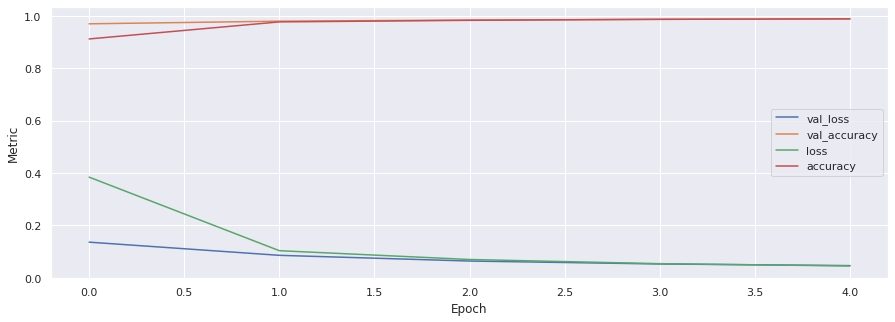

In [138]:
sns.set()
fig, ax = plt.subplots(figsize=(15,5))
history_df.plot(ax=ax)
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.show()

# Evaluate

In [139]:
print('\n# Evaluate on test data')
results = classifier.evaluate(test_x, test_y)
for i, metric in enumerate(classifier.metrics_names):
    print(f"{metric}: {results[i]}")


# Evaluate on test data
1000/1000 [==============================] - 2s 2ms/step
loss: 0.04175126233696937
accuracy: 0.9896199703216553


## Confusion Matrix

In [140]:
def remap(matrix):
    """
    Utility function to take one-hot encoded labels and return the label with the higest probability
    """
    
    #Switch index to label
    def switcher(x):
        return dummyIndex_label_dict[x]
    
    #Get the index along the second axis (the one-hot encoding) with the highest value
    predicted_index = pd.DataFrame(np.argmax(matrix, axis=2))
    
    #Use our dictionary to map this index to the class
    label_representation = predicted_index.applymap(switcher)

    return label_representation

In [141]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix

In [142]:
#Get the predicted classes for the test set
prediction_probabilities = classifier.predict(test_x)

predicted_classes = remap(prediction_probabilities)
true_classes = remap(test_y)

In [143]:
# Unravel it
predicted_classes = predicted_classes.values.reshape(-1,1)
true_classes = true_classes.values.reshape(-1,1)

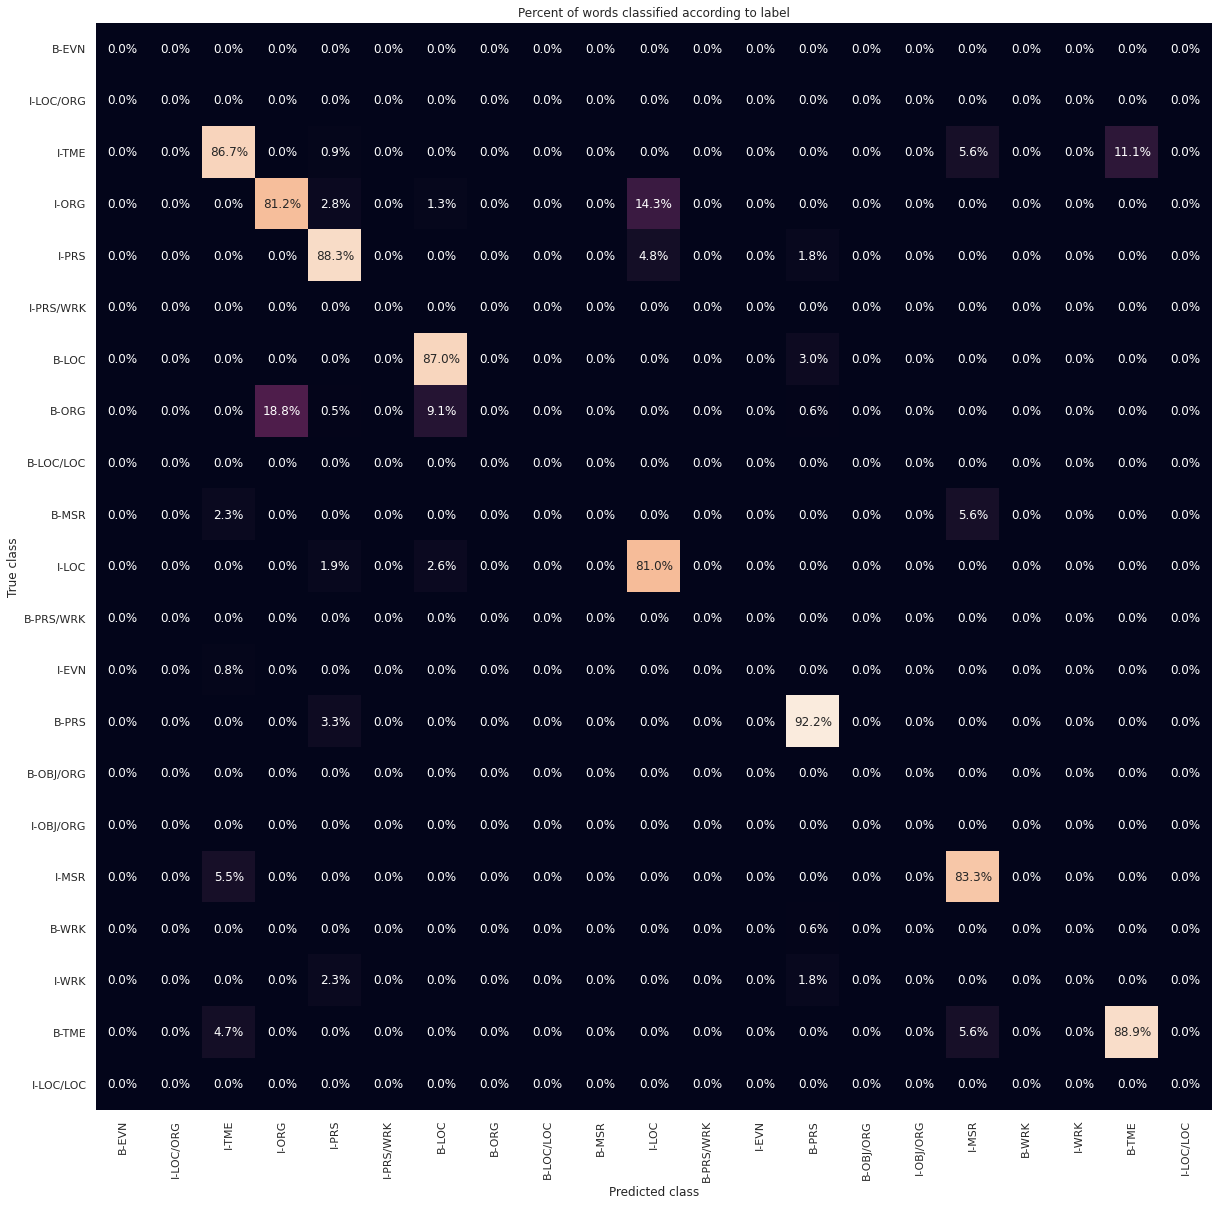

In [148]:
# The scikit confusion function also takes a list of labels. The generated confusion matrix will consist of the elements of this list, in the order they appear
cf_labels = list(dummyIndex_label_dict.values())

# We are great at padding, but that isn't super-interesting
cf_labels.remove('<pad>')
cf_labels.remove('[CLS]')
cf_labels.remove('[SEP]')
cf_labels.remove('B-LOC/ORG')
cf_labels.remove('B-LOC/PRS')
cf_labels.remove('I-LOC/PRS')
cf_labels.remove('B-ORG/PRS')
cf_labels.remove('I-OBJ')
cf_labels.remove('B-OBJ')
cf_labels.remove('B-O')
cf_labels.remove('I-O')
cf_labels.remove('I-ORG/PRS')

#Generate a confusion matrix
cmatrix = confusion_matrix(y_true=true_classes, y_pred=predicted_classes, labels = cf_labels)

#Use pandas for plotting purposes
cmatrix = pd.DataFrame(cmatrix, columns=cf_labels, index=cf_labels)

# The absolute number of things retrieved isn't as interesting as the relative retrival, so we normalize along the x-axis
cmatrix = cmatrix.apply(lambda x: x/x.sum(), axis = 0)

#Remove Nans
cmatrix = cmatrix.fillna(0)

#The confusion matrix is defined such that each row corresponds to a true label, each column is predicted label
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(cmatrix, ax = ax, annot=True, fmt=".1%", cbar=False)
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")
plt.title("Percent of words classified according to label")
plt.show()

## Generate Recall, Precision, F1-score for each label

In [149]:
from sklearn.metrics import classification_report

report = classification_report(y_true=true_classes, y_pred=predicted_classes, labels = cf_labels, output_dict=True, zero_division=0)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
B-EVN,0.000000,0.000000,0.000000,9.0
I-LOC/ORG,0.000000,0.000000,0.000000,0.0
I-TME,0.656805,0.555000,0.601626,200.0
I-ORG,0.722222,0.144444,0.240741,90.0
I-PRS,0.807692,0.780992,0.794118,242.0
I-PRS/WRK,0.000000,0.000000,0.000000,0.0
B-LOC,0.788235,0.592920,0.676768,113.0
B-ORG,0.000000,0.000000,0.000000,46.0
B-LOC/LOC,0.000000,0.000000,0.000000,0.0
B-MSR,0.000000,0.000000,0.000000,24.0
